# Separate movie and user embedding into two layers

Previously I manually concatenated one hot vectors for movies and users so that I could keep a simple DL pipeline architecture. This made it complicated to extract the embeddings for just the movies. I suspect I will have better luck with separate layers that I join after the embeddings. For training the network, I have adapted code from [Kaggle](https://www.kaggle.com/colinmorris/embedding-layers#Building-a-rating-prediction-model-in-Keras).

Start with 20,000 records, then play with hyper parameters, then see what the full data set looks like. Once again use a random forest as a metric of how good the embeddings are.

In [1]:
import pandas as pd
import numpy as np
import re
np.set_printoptions(precision=2, suppress=True, linewidth=3000, threshold=20000)

def load(n = 10):
    df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
    df_ratings = df_ratings.drop('timestamp', axis=1)
    df_ratings = df_ratings.sample(n=n).reset_index(drop=True)
    # Merge in the title and genres
    df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
    df = df_ratings.merge(df_movies, on='movieId')
    # Strip the "(1999)" dates from the titles
    p = re.compile(r'[()0-9]+$')
    df['title'] = df['title'].map(lambda x: p.sub('', x).strip())
    return df

def compress_cats(df, colname):
    df[colname] = df[colname].astype('category').cat.as_ordered()
    df[colname] = df[colname].cat.codes + 1 # encode 1..n

In [2]:
df = load(n=20_000)
df = df[(df['genres']=='Comedy')|(df['genres']=='Drama')]
nmovies = len(df.groupby('movieId').count())
compress_cats(df, 'movieId')
compress_cats(df, 'userId')
print(len(df), 'movies that are Comedy or Drama')
df.head(3)

2675 movies that are Comedy or Drama


,userId,movieId,rating,title,genres
152,280,2,3.0,Nixon,Drama
153,148,2,4.0,Nixon,Drama
154,274,2,4.0,Nixon,Drama


In [3]:
# get unique movie ID and title and genres
df_movies = df.sort_values('movieId')[['movieId','title','genres']]
df_movies = df_movies.drop_duplicates()

## Training a split then joined network

We are trying to map a sparse movie and user ID vector to a dense vector of say `dimensionality`=8, 10, or 20 dimensions. To do that, we use the first parallel layers of a network that have `dimensionality` neurons.  There is a parallel layer for movie and for user ID embedding, which are then joined and run through a pipeline for predicting ratings. Each neuron will contribute a single dimension to each dense vector. The input X has, say, 10,000 rows, one for each one hot movie ID. It has nmovies columns. If there are 10 movies, there are 10 possible positions in the one hot encoding. The first layer is a transformation from nmovies or nusers space to `dimensionality` space. The key is that we want to choke that first layers into just a few neurons and then have a big layer afterwards that tries to make sense of those new compressed features. We don't care about the prediction at the end, we are just going to take the weights out of the first parallel layers to get the embeddings.

In [4]:
# derivation of https://www.kaggle.com/colinmorris/embedding-layers#Building-a-rating-prediction-model-in-Keras
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks, optimizers
import tensorflow_addons as tfa
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def train(df,
          dimensionality = 8,
          otherlayers = (100,),
          batch_size = 10,
          epochs = 20,
          batchnorm = False,
          dropout = 0):
    # Everybody get one hot!
    nusers = len(df.groupby('userId').count())
    nmovies = len(df.groupby('movieId').count())
    X_movies = pd.get_dummies(df['movieId'])
    X_users = pd.get_dummies(df['userId'])
    y = df['rating']

    layer1 = dimensionality
    
    movie_id_input   = tf.keras.Input(shape=(nmovies,), name='movieId')
    user_id_input    = tf.keras.Input(shape=(nusers,), name='userId')

    movie_embeddings = layers.Dense(layer1, input_dim=nmovies, activation='relu', name='movie_embeddings')
    user_embeddings  = layers.Dense(layer1, input_dim=nusers, activation='relu',  name='user_embeddings')
    movie_embeddings = movie_embeddings(movie_id_input)
    user_embeddings  = user_embeddings(user_id_input)

    # Merge these layers as input to the subsequent dense layer(s)
    output = tf.keras.layers.Concatenate()([movie_embeddings, user_embeddings])

    # Add some hidden layers to feed off of these features
    for n_hidden in otherlayers:
        hidden = layers.Dense(n_hidden, activation='relu')
        output = hidden(output)
        if batchnorm:
            norm = layers.BatchNormalization()
            hidden = norm(output)
        if dropout>0.0:
            dr = layers.Dropout(dropout)
            hidden = dr(output)

    # Final layer just makes a prediction based upon the last hidden layer features
    last_layer = layers.Dense(1)
    output = last_layer(output)
    
    model = tf.keras.Model(
        inputs = [movie_id_input, user_id_input], # two one hot vectors as input
        outputs = output,
    )
#     print(model.summary())

    # Per https://www.kaggle.com/colinmorris/embedding-layers#Building-a-rating-prediction-model-in-Keras
    # "Technical note: when using embedding layers, I highly recommend using one of the optimizers
    # found  in tf.train: https://www.tensorflow.org/api_guides/python/train#Optimizers
    # Passing in a string like 'adam' or 'SGD' will load one of keras's optimizers (found under 
    # tf.keras.optimizers). They seem to be much slower on problems like this, because they
    # don't efficiently handle sparse gradient updates."
#     opt = tf.optimizers.RMSprop()
    opt = tf.optimizers.Adam(0.005)
    model.compile(loss='mean_squared_error',
                  optimizer=opt,
                  metrics=['mae'])
    
    history = model.fit(
        x=[X_movies, X_users],
        y=y,
        shuffle=True,
        epochs=epochs,
        validation_split=0.15,
        batch_size=batch_size,
        verbose=0,
        callbacks=[tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)]
    )
    return model, history

In [5]:
def plot_history(history, yrange=(0.0, 5.00)):
    plt.figure(figsize=(3.5,3))
    plt.ylabel("Rating (0..5.0) MAE")
    plt.xlabel("Epochs")
    accur = history.history['mae']
    plt.plot(accur, label='train_mae')
    val_accur = history.history['val_mae']
    plt.plot(val_accur, label='val_mae')
    # plt.xlim(0, 200)
    plt.ylim(*yrange)
    plt.legend(loc='lower right')
    plt.show()

In [6]:
model, history = train(df)

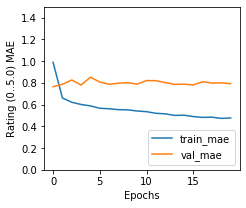

In [7]:
plot_history(history, yrange=(0,1.5))

## Getting the embeddings out of the network

Grab the weights and biases to use as the embeddings:

In [8]:
movie_layer = model.get_layer('movie_embeddings')
movie_weights, movie_biases = movie_layer.get_weights()
movie_weights.shape, movie_biases.shape

((940, 8), (8,))

In [9]:
user_layer = model.get_layer('user_embeddings')
user_weights, user_biases = user_layer.get_weights()
user_weights.shape, user_biases.shape

((441, 8), (8,))

## RF accuracy with embeddings

These embeddings are much better than I got when I tried to concatenate things with a single sequential pipeline. Definitely having separate embeddings makes a difference. It doesn't look like adding the bias makes a difference however to the accuracy at least with a random forest cross validation test.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def RF_onehot(df, movie_embeddings, user_embeddings):
    X = df[['movieId','userId']]
    y = df['rating']
    X_emb = np.concatenate([movie_embeddings[X['movieId']-1],user_embeddings[X['userId']-1]], axis=1)
#     X_train, X_test, y_train, y_test = train_test_split(X_emb, y, test_size=0.2)

    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    rf.fit(X_emb, y)
    scores = cross_val_score(rf, X_emb, y, cv=5)
    print(f"OOB R^2 {rf.oob_score_:.3f}")
    print(f"Train R^2 {rf.score(X_emb, y):.3f}")
    print(f"5-fold valid R^2 {np.mean(scores):.3f}")

In [11]:
RF_onehot(df, movie_weights, user_weights)

OOB R^2 0.515
Train R^2 0.934
5-fold valid R^2 0.518


In [12]:
RF_onehot(df, movie_weights+movie_biases, user_weights+user_biases)

OOB R^2 0.521
Train R^2 0.934
5-fold valid R^2 0.519


Wow! Switching from RMSProp to Adam optimizer made a huge difference and accuracy is R^2 0.51.

## Try different hyper parameters

The following data was with RMSProp() where I got it most .46 or .47 R^2:

* Going from 8 (each for movie and user) to 16 to 32 dimensionality seems to hurt accuracy a bit
* Dropping to four dimensionality seems not to hurt much
* Dropping to two drops R^2 from .4 to .35, but that is still amazing for just two dimensions
* Wow. Dropping to one dimension per movie end-user still gets .27 R^2! That is much better than using the plane categorical labeling coded values. somehow the network is finding a better labeling coding scheme!
* Increasing batch size from 10 to 50 seems to improve accuracy slightly. 100 slightly better or the same. 200 is too much as accuracy drops.
* 10 down from 20 epochs drops accuracy a bit.
* Increasing from 20 to 30 epochs increases accuracy a little. 50 epochs is pretty good: .45 R^2.
* Increasing single hidden layer from 100 to 200 doesn't seem to do much
* With (100,4) layers from (100,) it is slightly less accurate; (100,32) still about the same; (100,32,4) as a little bit worse
* Adding batch norm didn't seem to change much: `train(df, batch_size=50, epochs=50, otherlayers=(100,), batchnorm=True)`
* Adding a little bit of dropout seems to help: `train(df, batch_size=50, epochs=50, otherlayers=(100,), batchnorm=True, dropout=0.1)`; got to .46 and .47. Drop out of 0.2 and 0.3 our perhaps a little bit worse but certainly no better. Same for dropout=0.5

Adam() Optimizer does a better job apparently so let's replay some hyper parameter changes:

* Best with RMSProp was `train(df, batch_size=50, epochs=50, otherlayers=(100,), batchnorm=True, dropout=0.1)`
* With `train(df, batch_size=10, epochs=30, otherlayers=(100,), batchnorm=True, dropout=0.1)` I got .544
* Getting rid of batch norm and dropout gives me about the same thing `train(df, batch_size=10, epochs=30, otherlayers=(100,))`
* Dropping dimensionality to 4 seem to improve score slightly: `train(df, dimensionality=4, batch_size=10, epochs=30, otherlayers=(100,))`
* Increasing the number of epochs to 50 improved score to 0.596! 60 is too many though. 40 too few.

Scores bounce around a bit based upon sample taken and init conditions of network. :(

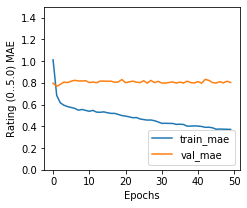

OOB R^2 0.520
Train R^2 0.934
5-fold valid R^2 0.533


In [13]:
model, history = train(df, dimensionality=4, batch_size=10, epochs=50, otherlayers=(100,), batchnorm=False, dropout=0.0)

plot_history(history, yrange=(0,1.5))

movie_layer = model.get_layer('movie_embeddings')
movie_weights, movie_biases = movie_layer.get_weights()
user_layer = model.get_layer('user_embeddings')
user_weights, user_biases = user_layer.get_weights()

RF_onehot(df, movie_weights, user_weights)

## Are the movies separate in embedding space projected onto 2D?

In [14]:
from sklearn.decomposition import PCA

def plot_embeddings(df_movies, movie_embeddings, xrange=(-.3,.3), yrange=(-.15,.15)):
    plt.figure(figsize=(5,5))
    movieIds = df_movies['movieId'].values
    genres = df_movies['genres'].values
    titles = df_movies['title'].values
    pca = PCA(n_components=2)
    vecs2D = pca.fit_transform(movie_embeddings)
    c = [('k' if 'Comedy' in genres[i] else 'r') for i in range(len(vecs2D))]
    plt.scatter(vecs2D[:,0], vecs2D[:,1], c=c, s=5)
    plt.xlim(*xrange)
    plt.ylim(*yrange)
    plt.show()

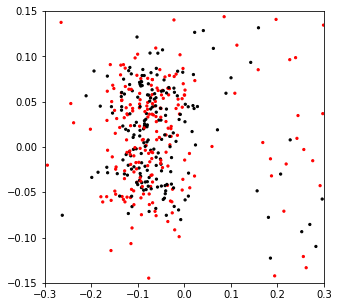

In [15]:
plot_embeddings(df_movies, movie_weights)

Well, those don't look super separated but there are more red comedies to the right and black dramas to the left.

# Try all the data

In [16]:
df = load(n=100_000)
df = df[(df['genres']=='Comedy')|(df['genres']=='Drama')]
nmovies = len(df.groupby('movieId').count())
compress_cats(df, 'movieId')
compress_cats(df, 'userId')
print(len(df), 'movies that are Comedy or Drama')
df.head(3)

13373 movies that are Comedy or Drama


,userId,movieId,rating,title,genres
295,265,680,4.5,Wall Street,Drama
296,202,680,2.0,Wall Street,Drama
297,528,680,3.0,Wall Street,Drama


In [17]:
# get unique movie ID and title and genres
df_movies = df.sort_values('movieId')[['movieId','title','genres']]
df_movies = df_movies.drop_duplicates()

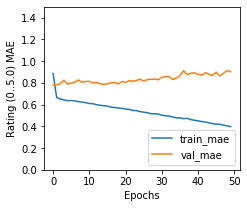

OOB R^2 0.428
Train R^2 0.922
5-fold valid R^2 0.397


In [18]:
model, history = train(df, dimensionality=16, batch_size=50, epochs=50, otherlayers=(100,), batchnorm=True, dropout=0.1)

plot_history(history, yrange=(0,1.5))

movie_layer = model.get_layer('movie_embeddings')
movie_weights, movie_biases = movie_layer.get_weights()
user_layer = model.get_layer('user_embeddings')
user_weights, user_biases = user_layer.get_weights()

RF_onehot(df, movie_weights, user_weights)

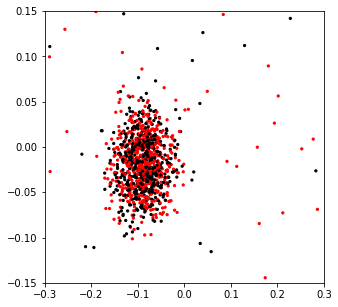

In [19]:
plot_embeddings(df_movies, movie_weights)